In [2]:
from Calibration import *

In [150]:

def run_model_cma(parameters, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, end_year):

 
   
    model = BMI_HBVmountain(forcing, path_to_shapefile, path_to_dem, path_to_nlcd)
    config_file = model.setup(forcing_netcdf=forcing, bare_parameters=  Parameters(parameters[8], parameters[6], 0, 0, parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[7], parameters[0]),
                                        forest_parameters=Parameters(parameters[11], parameters[6], 0, parameters[9], parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[10], parameters[0]),
                                        grass_parameters= Parameters(parameters[14], parameters[6], 0, parameters[12], parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[13], parameters[0]),
                                        rip_parameters=   Parameters(parameters[17], parameters[6], 0, parameters[15], parameters[18],
                                                                     parameters[1], parameters[2], parameters[3], parameters[16], parameters[0]),
                                        slow_parameters=  Slow_Paramters(parameters[5], parameters[19]))
    model.initialize(config_file)




    Discharge = []
    timestamp = []
    while (model.get_value_ptr('Current_Date') < (datetime.date(end_year, 12, 31))):  
        model.update()
        timestamp.append(model.get_value_ptr('Current_Date'))
        Discharge.append(model.get_value_ptr('Discharge'))

    simulated_discharge_df = pd.DataFrame(
            {'streamflow': Discharge},
            index=pd.to_datetime(timestamp)
        )
    
    precipitation = generate_forcing_from_NETCDF(forcing).prec
    model.finalize()
    return simulated_discharge_df.streamflow, precipitation



def transform(scaled_parameters):
    """Transforms the scaled_parameter to parameter.

    if x = scaled_parameter and y = parameter,
    then x is in the range [0, 10] and y is in the range [a, b].
    To map the values [0, 10] into [a, b],
    we use the transformations a + (b-a) * x/10.
    For more information on this transformation,
    please see
    http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
    """
    PARAMETERS_BOUNDS = [[-2.0, 2.0],
                 [1.0, 5.0],
                 [0.001, 1.0],
                 [0.1, 0.9],
                 [0.1, 3.0],
                 [0.001, 0.1],
                 [0.4, 0.8],
                 [1.0, 75.0],
                 [0.1, 2.0],
                 [1.0, 10.0],
                 [50.0, 750.0],
                 [0.1, 2.0],
                 [0.1, 5.0],
                 [5.0, 400.0],
                 [0.1, 2.0],
                 [0.1, 8.0],
                 [5.0, 400.0],
                 [0.1, 2.0],
                 [0.1, 3.0],
                 [0.05, 0.5]]
    parameters = []
    for scaled_parameter, bound in zip(scaled_parameters, PARAMETERS_BOUNDS):
        scale = (bound[1] - bound[0]) / 10.0
        parameter = bound[0] + (scale * scaled_parameter)
        parameters.append(parameter)
    return parameters

def wrapped_objective_function(scaled_parameters, observation, forcing, path_to_shapefile, path_to_dem, path_to_nlcd,start_year, years_warming_up, end_year):
    """A wrapper around the objective function.

    The wrapper transforms the scaled_parameters before
    the actual function call.
    """
    parameters = transform(scaled_parameters)
    if parameters[9] < parameters[12]: #if Imax,forest < Imax,grass
        parameters[12] = parameters[9] - 0.001
    if parameters[9] < parameters[15]: #if Imax,forest < Imax,rip
        parameters[15] = parameters[9] - 0.001         
    if parameters[10] < parameters[13]: #if Su,max,forest < if Su,max,grass
        parameters[13] = parameters[10] - 0.001
    if parameters[13] < parameters[16]: #if Su,max,grass < Su,max,rip
        parameters[16] = parameters[13] - 0.001  
    if parameters[13] < parameters[7]: #if Su,max,grass < Su,max,bare
        parameters[7] = parameters[13] - 0.001  
    if parameters[18] < parameters[4]: #if Kf,rip < Kf
        parameters[4] = parameters[18] - 0.001  
    # print(parameters)
    Qmodelled, precipitation = run_model_cma(parameters, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, end_year)
    precipitation.index, Qmodelled.index, observation.index = pd.to_datetime(precipitation.index), pd.to_datetime(Qmodelled.index), pd.to_datetime(observation.index)
    mask = (observation.index >= Qmodelled.index[0]) & (observation.index <= Qmodelled.index[-1])
    observation = observation.loc[mask]

    ED = multi_objective(Qmodelled.loc[Qmodelled.index.year >= (start_year+years_warming_up)], observation.loc[observation.index.year >= (start_year+years_warming_up)], precipitation)[0] 
    return ED

def cma_calibration(parameter_bounds, observation, MAXITER, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, start_year, years_warming_up, end_year):
    """Return the optimum parameters found by CMA-ES method."""
    # Set some options for optimization needed when multiprocessing
    options = cma.CMAOptions()
    POPSIZE =8
    options.set({
        'bounds': [0, 10],  # for scaled parameters
#         'seed': 1234,  # set a seed to reproduce results
        'verbose': -9,  # verbosity of initial/final message: maximally quiet
        'popsize': POPSIZE,
        'maxiter': MAXITER,
        'tolfun': 1e-17,  # very small value due to model creeping behavior
        'tolx': 1e-5
    #         'verb_filenameprefix': ('output_dir'),  # cma-es output path
    })

    no_of_variables = len(parameter_bounds)
    # initial mean value and standard deviation
    x0 = 5.0
    sigma0 = 2.0

    # Initialize the CMA-ES
    cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

    # Store the results of each iteration
    all_scores = []
    all_parameters = []

    # Use parallel processing
    # with EvalParallel2(number_of_processes=options['popsize']) as evaluations:
        # Use ask-and-tell interface
    while not cma_es.stop():
        solutions = cma_es.ask()
        cma_es.tell(
            solutions,

            [wrapped_objective_function(x, observation, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, start_year, years_warming_up, end_year) for x in solutions]
                
            )
        parameters = transform(cma_es.best.last.x)
        if parameters[9] < parameters[12]: #if Imax,forest < Imax,grass
            parameters[12] = parameters[9] - 0.001
        if parameters[9] < parameters[15]: #if Imax,forest < Imax,rip
            parameters[15] = parameters[9] - 0.001         
        if parameters[10] < parameters[13]: #if Su,max,forest < if Su,max,grass
            parameters[13] = parameters[10] - 0.001
        if parameters[13] < parameters[16]: #if Su,max,grass < Su,max,rip
            parameters[16] = parameters[13] - 0.001  
        if parameters[13] < parameters[7]: #if Su,max,grass < Su,max,bare
            parameters[7] = parameters[13] - 0.001  
        if parameters[18] < parameters[4]: #if Kf,rip < Kf
            parameters[4] = parameters[18] - 0.001  
        # Use transform to return parameters and not scaled ones
        all_parameters.append(parameters)
        all_scores.append(cma_es.best.last.f)
#     print(f"---- CMA-ES stopped due to: {cma_es.stop()} ----")
    best_parameter = transform(cma_es.result.xbest)
    if best_parameter[9] < best_parameter[12]: #if Imax,forest < Imax,grass
        best_parameter[12] = best_parameter[9] - 0.001
    if best_parameter[9] < best_parameter[15]: #if Imax,forest < Imax,rip
        best_parameter[15] = best_parameter[9] - 0.001         
    if best_parameter[10] < best_parameter[13]: #if Su,max,forest < if Su,max,grass
        best_parameter[13] = best_parameter[10] - 0.001
    if best_parameter[13] < best_parameter[16]: #if Su,max,grass < Su,max,rip
        best_parameter[16] = best_parameter[13] - 0.001  
    if best_parameter[13] < best_parameter[7]: #if Su,max,grass < Su,max,bare
        best_parameter[7] = best_parameter[13] - 0.001  
    if best_parameter[18] < best_parameter[4]: #if Kf,rip < Kf
        best_parameter[4] = best_parameter[18] - 0.001 
    # Make full output
    full_output = (best_parameter,
                   cma_es.result.fbest,
                   all_parameters,
                   all_scores)
    return full_output


def full_calibration(ntimes, path_to_observation, MAXITER, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, start_year, years_warming_up, end_year):
    exec_start_time = time.time()
    PARAMETERS_BOUNDS = [[-2.0, 2.0],
                     [1.0, 5.0],
                     [0.001, 1.0],
                     [0.1, 0.9],
                     [0.1, 3.0],
                     [0.001, 0.1],
                     [0.4, 0.8],
                     [1.0, 75.0],
                     [0.1, 2.0],
                     [1.0, 10.0],
                     [50.0, 750.0],
                     [0.1, 2.0],
                     [0.1, 5.0],
                     [5.0, 400.0],
                     [0.1, 2.0],
                     [0.1, 8.0],
                     [5.0, 400.0],
                     [0.1, 2.0],
                     [0.1, 3.0],
                     [0.05, 0.5]]
    area = gpd.read_file(path_to_shapefile).area_hys.values[0] #km2
    observation = pd.read_csv(path_to_observation, index_col=0).streamflow / (area * 1e6) * 1000 *86400
    ob_list = []
    params_list = []
    results_doc_list = []
    for n in range(ntimes):
        full_output = cma_calibration(PARAMETERS_BOUNDS, observation, MAXITER, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, start_year, years_warming_up, end_year)
        best_par, best_score, pars, scores = full_output
        
        simulated_discharge, precipitation = run_model_cma(best_par, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, end_year)
        mask = (observation.index >= simulated_discharge.index[0]) & (observation.index <= simulated_discharge.index[-1])
        observation = observation.loc[mask]
        
        objective_function = multi_objective(simulated_discharge.loc[simulated_discharge.index.year >= (start_year+ years_warming_up)], observation.loc[observation.index.year >= (start_year+ years_warming_up)], precipitation)
        ob_list.append(objective_function)
        params_list.append(best_par)   
        

        
        
        other_values = [
            ([float(z) for z in x], float(1 - y)) for x, y in zip(pars, scores)
        ]
        results_doc = {
            'title': f'HBVmountain model optimized parameter based on ED,{n+1}st simulation',
            'best_parameter_value': [float(x) for x in best_par],
            'best_NSE_value': float(1 - best_score),
            'other_values': other_values,
        }

        results_doc_list.append(results_doc)
    paramset = pd.DataFrame(columns=['ED', 'NSE', 'logNSE', 'NSEfdc', 'NSErunoff', 'Temp_Thresh', 'Meltfactor', 'Mm', 'Ratio_Pref', 'Kf', 'Ks', 'Ce', 'Soilstoragecapacity_Bare', 'beta_Bare', 'Interceptioncapacity_Forest', 'Soilstoragecapacity_Forest', 'beta_Forest', 'Interceptioncapacity_Grass', 'Soilstoragecapacity_Grass', 'beta_Grass', 'Interceptioncapacity_Rip', 'Soilstoragecapacity_Rip', 'beta_Rip', 'Kf_Rip', 'Ratio_Riparian'])
    for i in range(len(ob_list)):
        paramset.loc[i] = [ob_list[i][0], ob_list[i][1], ob_list[i][2], ob_list[i][3], ob_list[i][4], params_list[i][0], params_list[i][1], params_list[i][2], params_list[i][3], params_list[i][4], params_list[i][5], params_list[i][6], params_list[i][7], params_list[i][8], params_list[i][9], params_list[i][10], params_list[i][11], params_list[i][12], params_list[i][13], params_list[i][14], params_list[i][15], params_list[i][16], params_list[i][17], params_list[i][18], params_list[i][19]]
    paramset.ED = 1 - paramset.ED
    
    grdc_no = str(int(gpd.read_file(path_to_shapefile).grdc_no[0]))
    name = '_cma_calibration.yml'
    filename = grdc_no + name
    yaml = YAML()
    yaml.default_flow_style = False
    with open(filename, 'w+') as f:
        yaml.dump(results_doc_list, f)
    print(f'Calibration results saved in {filename}')
    print(f"Calibration is completed in {time.time() - exec_start_time} seconds")
    return paramset


In [151]:
forcing = nc.Dataset('Data/ThunderCreek/HBVmountain_ERA5_ThunderCreek_1986_2005.nc')

In [156]:
ntimes = 1
MAXITER = 50
path_to_observation = 'Data/ThunderCreek/Discharge_ThunderCreek.csv' #GRDC observation data
path_to_shapefile = 'Data/ThunderCreek/Shapes/Thundercreek.shp' #Catchment shapefile from GRDC
path_to_dem = 'Data/ThunderCreek/dem_thundercreek_full.tif' #DEM tiles over the catchment area
path_to_nlcd = 'Data/NLCD_2001_Landuse.tif' 
start_year = 1986
years_warming_up = 2
end_year_calibration = 1995
end_year_validation = 2004

In [157]:
calibration_results = full_calibration(ntimes, path_to_observation, MAXITER, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, start_year, years_warming_up, end_year_calibration)

Calibration results saved in cma_calibration_thundercreek.yml
Calibration is completed in 3124.7996706962585 seconds


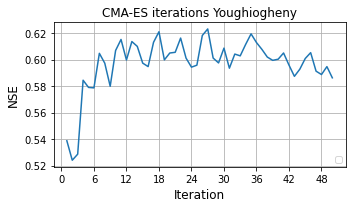

In [11]:
def plot_parameters(results):
    """Make a plot showing optimization results."""
    
    # Create a figure with left and right axis
    fig, ax = plt.subplots(figsize=(5, 3))

    # Plot NSE vs. iteration index obtained by calibration
    label_text = {}
    data = results["other_values"]
    all_parameters, all_scores = list(zip(*data))
    ax.plot(range(1, len(all_scores) + 1), all_scores)

    # Add parameters of each iteration as a text
    iterations = []
    for iteration, parameters in enumerate(all_parameters):
        parameters_as_str = ', '.join(f'{par:.2f}' for par in parameters)
        iterations.append(f"{iteration + 1}: {parameters_as_str}")
    label_text = '\n'.join(iterations)

    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_ylabel("NSE", fontsize=12)
    ax.set_title("CMA-ES iterations Youghiogheny")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis is integer

    # Combine and plot legend
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='lower right', prop={"size": 8})

#     # Add statistics
#     best_parameters = ', '.join(
#         f"{par:.2f}" for par in results['best_parameter_value']
#     )
#     statistics = "\n".join(
#         [
#             f"best NSE value: {results['best_NSE_value']:.2f}",
#             f"best parameters: {best_parameters}",
#             "-------------------------------",
#             "Iterations, parameters",
#             f"{label_text}",
#         ]
#     )

#     box = {"edgecolor": "blue", "facecolor": "white"}
#     ax.text(
#         1.06,
#         0.98,
#         statistics,
#         transform=ax.transAxes,
#         va="top",
#         bbox=box,
#         fontsize=6,
#     )

    # Show grid
    plt.grid(True)

    # Fix legend falling off figure
    fig.tight_layout()
    plt.show()

    return fig


# it is located in the output directory
yaml = YAML()
from matplotlib.ticker import MaxNLocator

filename = "cma_calibration_youghiogheny.yml" 
with open(filename) as f:
    calibration_results = yaml.load(f)
fig = plot_parameters(calibration_results[0])
# fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=300)

In [164]:
calibration_results

[ordereddict([('title', 'HBVmountain model optimized parameter based on ED,1st simulation'), ('best_parameter_value', [0.06627206111830208, 4.116509524356633, 0.40391463846930686, 0.24677144814372362, 1.4719543450446968, 0.06358449146391817, 0.5998174913819334, 44.939842788387054, 0.9769117365923758, 4.2480120487524236, 413.60945516838336, 1.7230944547105116, 1.5649977203660548, 399.4431778198863, 1.5763948054547803, 3.0850735397554674, 184.76601878494918, 0.29424927996109274, 2.395232317465466, 0.19269402417748294]), ('best_NSE_value', 0.6880268324429526), ('other_values', [[[-0.37456540251689674, 3.5385565014992233, 0.48920945975338526, 0.3163532847405182, 0.5564708513061246, 0.07299199248203578, 0.6303218809713347, 45.171168170521014, 1.2479574322601623, 6.510636064254484, 244.12362694062105, 0.9250714069901236, 1.441716074282026, 184.91010825406906, 0.7485643075103922, 4.592313204527859, 94.04611505821669, 1.1236277257249407, 0.986951917022744, 0.26837677263829784], 0.6639161397567

In [92]:
options = cma.CMAOptions()
POPSIZE = 25
options.set({
    'bounds': [0, 10],  # for scaled parameters
#         'seed': 1234,  # set a seed to reproduce results
    'verbose': -9,  # verbosity of initial/final message: maximally quiet
    'popsize': 8,
    'maxiter': 15,
    'tolfun': 1e-17,  # very small value due to model creeping behavior
    'tolx': 1e-5
#         'verb_filenameprefix': ('output_dir'),  # cma-es output path
})

no_of_variables = 20
# initial mean value and standard deviation
x0 = 5.0
sigma0 = 2.0

# Initialize the CMA-ES
cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)
scaled_parameters = cma_es.ask()


In [117]:
PARAMETERS_BOUNDS = [[-2.0, 2.0],
             [1.0, 5.0],
             [0.001, 1.0],
             [0.1, 0.9],
             [0.1, 3.0],
             [0.001, 0.1],
             [0.4, 0.8],
             [1.0, 75.0],
             [0.1, 2.0],
             [1.0, 10.0],
             [50.0, 750.0],
             [0.1, 2.0],
             [0.1, 5.0],
             [5.0, 400.0],
             [0.1, 2.0],
             [0.1, 8.0],
             [5.0, 400.0],
             [0.1, 2.0],
             [0.1, 3.0],
             [0.05, 0.5]]
parameters = []
for scaled_parameter, bound in zip(scaled_parameters, PARAMETERS_BOUNDS):
    scale = (bound[1] - bound[0]) / 10.0
    # print(scale)
    parameter = bound[0] + (scale * scaled_parameter)
    # print(parameter)
    parameters.append(parameter)
print(parameters)

[array([-0.43176791, -1.26434389, -1.62425379,  0.18661918, -0.78695125,
       -0.11565381,  1.70164747, -0.31033169, -0.60970586, -1.47238833,
       -1.02865527,  0.03033265, -0.62220049,  1.26551116, -0.64609238,
       -0.16239363, -0.218908  ,  0.00180691,  0.85645816,  0.72420076]), array([4.99967261, 4.22774642, 2.10951437, 3.12939358, 4.33349136,
       2.63663781, 2.5614169 , 3.83663089, 3.07422204, 2.24942407,
       4.28338159, 2.70247444, 1.97426061, 3.14172248, 2.95446677,
       3.52075002, 2.78806522, 2.15987913, 2.7112312 , 4.19645536]), array([0.46014074, 0.36387141, 0.79500605, 0.25159665, 0.17932682,
       0.48968882, 0.69796796, 0.31538095, 0.74119905, 0.4346916 ,
       0.5085103 , 0.74013405, 0.66656256, 0.31637003, 0.33376205,
       0.60930669, 0.29660265, 0.69269337, 0.25969907, 0.48376931]), array([0.62145902, 0.47499463, 0.52009781, 0.68667605, 0.3863101 ,
       0.64663645, 0.6633803 , 0.5717024 , 0.57347655, 0.39867734,
       0.18805938, 0.6725453 , 0.56

In [57]:
transform(solutions)

[array([ 4.02093342e-01,  1.99965514e+00,  4.16336879e-01,  1.50520042e-03,
         3.99510830e-01,  1.49625045e+00,  6.43331350e-02, -8.68126123e-01,
        -5.46791187e-01, -1.02864110e-01, -3.52316845e-01,  5.43400414e-01,
        -3.26913636e-01, -3.99327281e-01, -6.28294626e-01,  6.41171783e-01,
        -9.46377534e-02,  4.57169851e-01, -3.85565600e-01, -9.89628657e-02]),
 array([3.02689212, 3.51286008, 2.34506159, 3.52060841, 2.65064724,
        3.8193819 , 3.94319897, 2.46574747, 3.51666765, 3.13107787,
        4.25278875, 3.3352937 , 1.31660318, 3.8835046 , 3.4616136 ,
        3.50449573, 3.90173761, 2.4106854 , 3.30158827, 3.54671802]),
 array([0.5831214 , 0.17523401, 0.8136749 , 0.4269277 , 0.49355149,
        0.20090671, 0.55480633, 0.50007401, 0.51097347, 0.12890501,
        0.52869098, 0.55225555, 0.28107068, 0.04910616, 0.5247153 ,
        0.64680366, 0.94816051, 0.35900695, 0.43117016, 0.43891205]),
 array([0.28791264, 0.628815  , 0.59119599, 0.2709032 , 0.82168255,
  

In [28]:
transform(solutions)

[array([ 1.05006513,  0.10163385, -0.18349593, -0.3645952 ,  0.51923914,
        -1.00663732,  0.69789375, -0.2535732 , -0.41319639, -0.31058719,
         1.00361413,  0.57490138, -0.23189241, -0.56935106,  0.35830323,
        -0.21230097, -0.79797886, -0.69861121, -0.65396321, -1.46138093]),
 array([3.71383751, 4.97081588, 3.20890506, 1.8764246 , 1.00382181,
        4.01233006, 3.01856024, 4.50148925, 2.18277288, 3.76930063,
        2.44802228, 3.42020011, 2.82472467, 2.68031265, 1.37075629,
        3.02788703, 2.81506066, 2.46405445, 4.39602889, 4.02530302])]